In [55]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [56]:
d1 = pd.read_csv("LKO collocated sites data/1. BR Ambedkar_Dec2021_Nov2022.csv", index_col='Timestamp')
d1.head()

,Reference,Sensor
Timestamp,,
17-12-2021 11:00,38.1400,61.00
17-12-2021 12:00,33.6825,57.50
17-12-2021 13:00,31.4075,53.75
17-12-2021 14:00,30.3500,54.25
17-12-2021 15:00,31.4350,56.25


In [57]:
d1.drop(['Reference'], axis=1, inplace=True)
d1

,Sensor
Timestamp,
17-12-2021 11:00,61.00
17-12-2021 12:00,57.50
17-12-2021 13:00,53.75
17-12-2021 14:00,54.25
17-12-2021 15:00,56.25
...,...
30-11-2022 19:00,106.00
30-11-2022 20:00,142.75
30-11-2022 21:00,133.25


In [58]:
d1.info()
data = d1.values

<class 'pandas.core.frame.DataFrame'>
Index: 6213 entries, 17-12-2021 11:00 to 30-11-2022 23:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sensor  6213 non-null   float64
dtypes: float64(1)
memory usage: 97.1+ KB


In [59]:
data

array([[ 61.  ],
       [ 57.5 ],
       [ 53.75],
       ...,
       [133.25],
       [140.75],
       [143.5 ]])

In [60]:
def split_dataset_into_seq(dataset, start_index=0, end_index=None, history_size=13, step=1):
    '''split the dataset to have sequence of observations of length history size'''
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

In [63]:
def split_dataset(data, TRAIN_SPLIT=0.7, VAL_SPLIT=0.5, save_path=None):

    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std
    stats = (data_mean, data_std)

    data_in_seq = split_dataset_into_seq(data, start_index=0, end_index=None, history_size=13, step=1)

    train_data, val_data = train_test_split(data_in_seq, train_size=TRAIN_SPLIT, shuffle=False, random_state=123)
    val_data, test_data = train_test_split(val_data, train_size=VAL_SPLIT, shuffle=False, random_state=123)

    return train_data, val_data, test_data

In [64]:
device = torch.device("cpu")
print(f"device = {device}")

device = cpu


In [65]:
def split_fn(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], device=device)
    targets = torch.tensor(chunk[:, 1:, :], device=device)
    return inputs.float(), targets.float()

In [66]:
def data_to_dataset(train_data, val_data, test_data, batch_size=8):
    x_train, y_train = split_fn(train_data)
    x_val, y_val = split_fn(val_data)
    x_test, y_test = split_fn(test_data)
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

In [69]:
train_data, val_data, test_data = split_dataset(data)
train_dataset, val_dataset, test_dataset = data_to_dataset(train_data, val_data, test_data)

In [70]:
train_data.shape, val_data.shape, test_data.shape

((4340, 13, 1), (930, 13, 1), (930, 13, 1))

In [71]:
for x, y in train_dataset:
    print(x.shape)
    print(y.shape)
    break

torch.Size([8, 12, 1])
torch.Size([8, 12, 1])


In [72]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):

        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x.float()

    def split_heads(self, x):

        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x.float()

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output.float(), attention_weights.float()

In [73]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [74]:

def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=20, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

In [75]:

def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask.float()  # (size, size)

In [76]:
create_look_ahead_mask(6)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [77]:
class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [78]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [79]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                    dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [80]:

transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=1, out_features=1, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(train_dataset))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)

out, attn = transformer (x=inputs.float(), mask=mask.float())
out.shape, attn["decoder_layer1"].shape

(torch.Size([8, 12, 1]), torch.Size([8, 1, 12, 12]))

In [81]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6561 parameters 


In [82]:
transformer = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=1, out_features=1, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(), 
                                lr=0.00005)

In [85]:
for x, y in train_dataset:
    print(x.shape)
    print(y.shape)
    break

torch.Size([8, 12, 1])
torch.Size([8, 12, 1])


In [89]:
for x, y in val_dataset:
    print(x.shape)
    print(y.shape)
    break

torch.Size([8, 12, 1])
torch.Size([8, 12, 1])


In [86]:
m = create_look_ahead_mask(x.shape[1])
o, _ = transformer(x.float(), mask.float())

In [90]:
print(o.shape)
# print(o)

torch.Size([8, 12, 1])


In [83]:
from tqdm import tqdm

n_epochs = 20
niter = len(train_dataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):
    
    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in train_dataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x.float(), mask.float())
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)
    
    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(val_dataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x.float(), mask.float())
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
    val_losses.append(sum_val_loss / (i + 1))

100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


In [84]:
out.shape

torch.Size([2, 12, 1])

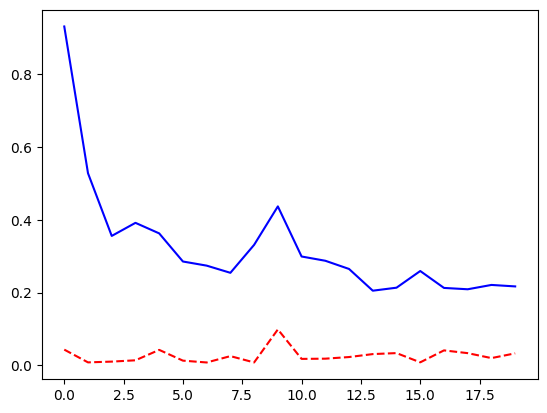

In [91]:
plt.plot(losses, 'b-')
plt.plot(val_losses, 'r--');

In [97]:
test_losses, test_preds, test_labels  = [], [], []
transformer.eval()
for (x, y) in test_dataset:
    S = x.shape[-2]
    y_pred, _ = transformer(x,
                            mask=create_look_ahead_mask(S))
    loss_test = torch.nn.MSELoss()(y_pred, y)  # (B,S)
    test_losses.append(loss_test.item())
    test_preds.append(y_pred.detach().cpu().numpy())
    test_labels.append(y.cpu().numpy())

    
test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)

print(test_preds.shape)
print(test_labels.shape)

np.mean(test_losses)


(930, 12, 1)
(930, 12, 1)


0.12905142415696993

In [98]:
from torchmetrics import R2Score

In [100]:
r2 = R2Score(num_outputs=12)

In [104]:
r2(torch.FloatTensor(test_preds).squeeze(2), torch.FloatTensor(test_labels).squeeze(2)).item()

0.7746930718421936

In [118]:
a1 = torch.FloatTensor(test_preds[:, 11]).view(-1)
a2 = torch.FloatTensor(test_labels[:, 11]).view(-1)

print(a1.shape)
print(a2.shape)

r2_0 = R2Score(num_outputs=1)
r2_0(a1, a2).item()

torch.Size([930])
torch.Size([930])


0.7130229473114014

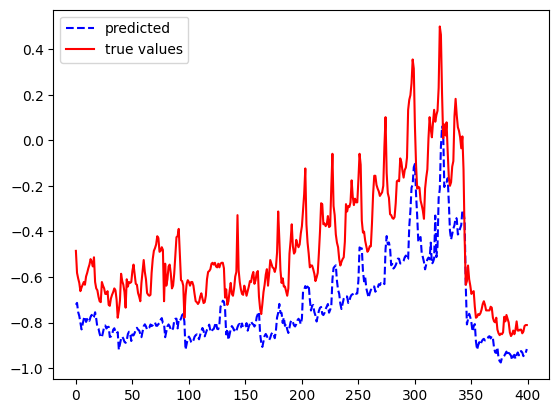

In [124]:
t = np.arange(400)
plt.plot(t, a1.numpy()[:400], 'b--', label="predicted")
plt.plot(t, a2.numpy()[:400], 'r-', label="true values")
plt.legend();

In [27]:
# def polyfit(x, y, degree):
#     results = {}

#     coeffs = numpy.polyfit(x, y, degree)

#      # Polynomial Coefficients
#     results['polynomial'] = coeffs.tolist()

#     # r-squared
#     p = numpy.poly1d(coeffs)
#     # fit values, and mean
#     yhat = p(x)                         # or [p(z) for z in x]
#     ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
#     ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
#     sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
#     results['determination'] = ssreg / sstot

#     return results

In [28]:
# sklearn.metrics.r2_score(y, test_preds)

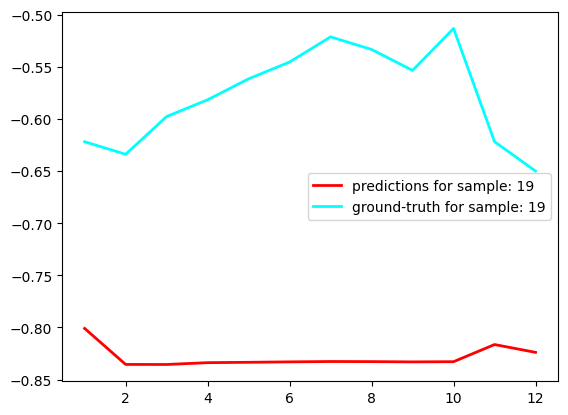

In [50]:
# Display predictions vs ground truth: 
# we'll take one random element of the first batch
# and display the first feature
seq_len = 12
index = np.random.randint(32)
feature_num = 0

x_test, _ = test_dataset.dataset.tensors
x_test = x_test[index, :, feature_num].cpu().numpy()
pred = test_preds[index, :, feature_num]
x = np.linspace(1, seq_len, seq_len)
plt.plot(x, pred, 'red', lw=2, label='predictions for sample: {}'.format(index))
plt.plot(x, x_test, 'cyan', lw=2, label='ground-truth for sample: {}'.format(index))
plt.legend(fontsize=10)
plt.show()


In [38]:
test_preds.shape

(930, 12, 1)

In [53]:
test_data.shape

(930, 13, 1)

In [48]:
test_preds[0:2, :, :]

array([[[ 1.17674255e+00],
        [ 1.48086596e+00],
        [ 2.17753077e+00],
        [ 3.34072661e+00],
        [ 4.98956442e+00],
        [ 5.68639469e+00],
        [ 6.37907600e+00],
        [ 6.08572865e+00],
        [ 5.77660799e+00],
        [ 5.61613846e+00],
        [ 5.33323383e+00],
        [ 4.85706615e+00]],

       [[ 8.78063738e-01],
        [ 7.45679617e-01],
        [ 8.06937695e-01],
        [ 1.14993322e+00],
        [ 1.57554722e+00],
        [ 9.53368425e-01],
        [ 5.11386514e-01],
        [ 2.79215455e-01],
        [ 2.56855369e-01],
        [-2.45237350e-03],
        [-1.05181396e-01],
        [-1.08304024e-01]]], dtype=float32)

In [49]:
test_data[0:2, :, :]

array([[[ 1.22403243],
        [ 1.5417536 ],
        [ 2.23752273],
        [ 3.33547056],
        [ 4.85168422],
        [ 5.52734442],
        [ 6.25930964],
        [ 5.91343597],
        [ 5.55147515],
        [ 5.36245116],
        [ 5.03266463],
        [ 4.48167983],
        [ 3.31938341]],

       [[ 0.94652913],
        [ 0.80576659],
        [ 0.91837663],
        [ 1.3245771 ],
        [ 1.69860329],
        [ 0.97468164],
        [ 0.39956612],
        [ 0.07782316],
        [ 0.03760529],
        [-0.01467794],
        [-0.13533154],
        [-0.14337512],
        [-0.17152763]]])